# 1. Prepare plotting scripts

In [106]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [29]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.models.wrapper.core.ActivationsExtractorHelper._from_sentences_stored"

In [30]:
def get_last_layer(model_identifier):
    """
    input: model_identifier of model of which we want to find the last layer
    output: last layer identifier
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        if "identifier=" + model_identifier in filename:
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layers = np.unique(result.layer)
            final_layer = layers[-1]
            return final_layer
            break

In [31]:
def get_all_layers(model_identifier):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        if "identifier=" + model_identifier in filename:
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layers = np.unique(result.layer)
            return layers
            break

In [32]:
def get_passage_identifier(filename):
    """
    get passage identifier to be used as key for the dictionary.
    important step: fill the identifier with 0s for single-digit passage numbers
    """
    passage = filename.split(",")[-1].split("-")[-1].split(".")[0]
    number = passage.split("sentences")[-1]
    if len(number) == 1:
        passage_identifier = passage[:-1] + number.zfill(2)
    else:
        passage_identifier = passage
    return passage_identifier

In [153]:
def get_dictionary(model_identifier, layer_identifier=None):
    """
    input: model identifier
    output: populated model dictionary with data of just the selected layer
    dictionary structure: passage_identifier --> condition identifier --> data
    """
    model_dictionary = model_identifier + "_dict"
    model_dictionary = {}
    
    #look at last layer by default
    if layer_identifier == None:
        layer_identifier = get_last_layer(model_identifier)
    else:
        layer_identifier = layer_identifier
    print("This is the layer I'm looking at: ", layer_identifier)
    
    for filename in tqdm(os.listdir(working_dir)):
        if "identifier=" + model_identifier in filename:
            passage_identifier = get_passage_identifier(filename)
            condition = filename.split(",")[-1].split("-")[-2]
        
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
            result = out['data']
            data = result[{"neuroid": [layer == layer_identifier for layer in result["layer"].values]}]
        
            if not passage_identifier in model_dictionary:
                model_dictionary[passage_identifier] = {}
            model_dictionary[passage_identifier][condition] = data
    
    return model_dictionary
        

In [103]:
def get_arrays(dictionary):
    #sort dictionary by passage identifier
    sorted_dict = dict(sorted(dictionary.items()))
    #create empty arrays
    original,scr1,scr3,scr5,scr7,lowpmi,backward,random = ([] for i in range(8))
    #
    for key, value in sorted_dict.items(): #key is passage, value is dic from cond to xarray data
        original.append(value['Original'].values)
        scr1.append(value['Scr1'].values)
        scr3.append(value['Scr3'].values)
        scr5.append(value['Scr5'].values)
        scr7.append(value['Scr7'].values)
        lowpmi.append(value['lowPMI'].values)
        backward.append(value['backward'].values)
        random.append(value['random'].values)
    return original,scr1,scr3,scr5,scr7,lowpmi,backward,random

In [89]:
def flatten_array(liste):
    liste_flatten = [item for sublist in liste for item in sublist]
    return liste_flatten

In [105]:
def prepare_dataframe(original,scr1,scr3,scr5,scr7,lowpmi,backward,random):
    df = pd.DataFrame(data={'Original':np.asarray(flatten_array(original)).flatten(),
                             'Scr1':np.asarray(flatten_array(scr1)).flatten(),
                              'Scr3':np.asarray(flatten_array(scr3)).flatten(),
                              'Scr5':np.asarray(flatten_array(scr5)).flatten(),
                              'Scr7':np.asarray(flatten_array(scr7)).flatten(),
                              'lowpmi':np.asarray(flatten_array(lowpmi)).flatten(),
                              'backward':np.asarray(flatten_array(backward)).flatten(),
                              'random':np.asarray(flatten_array(random)).flatten()})
    return df

In [151]:
def main_df_for_plotting(model_identifier, layer_identifier=None):
    model_dict = get_dictionary(model_identifier, layer_identifier)
    df = prepare_dataframe(*get_arrays(model_dict)) #*flattens the tuple
    return df

_____________________________________________________
_____________________________________________________

# Ready to plot!

# 1. Plot ClusterGrids for final layer

In [121]:
df_distilgpt2 = main_df_for_plotting("distilgpt2")

100%|██████████| 4200/4200 [00:18<00:00, 228.51it/s]


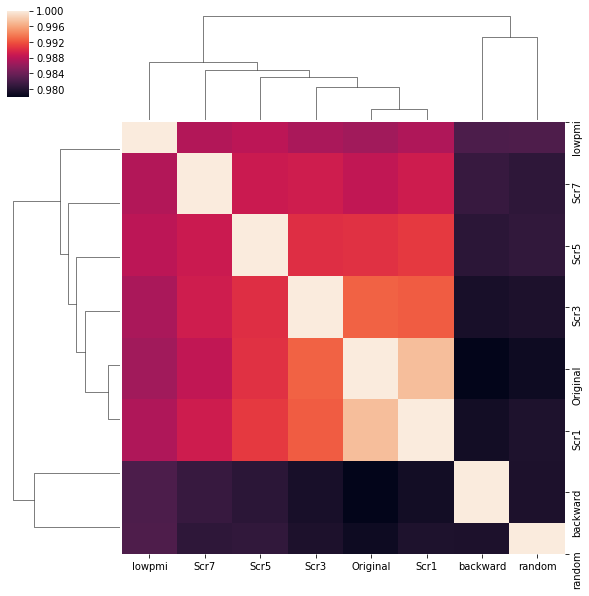

In [122]:
#sns.heatmap(df.corr())
#sns.heatmap(df.corr(method='spearman'))
sns.clustermap(df_distilgpt2.corr())

100%|██████████| 4200/4200 [00:14<00:00, 286.51it/s]  


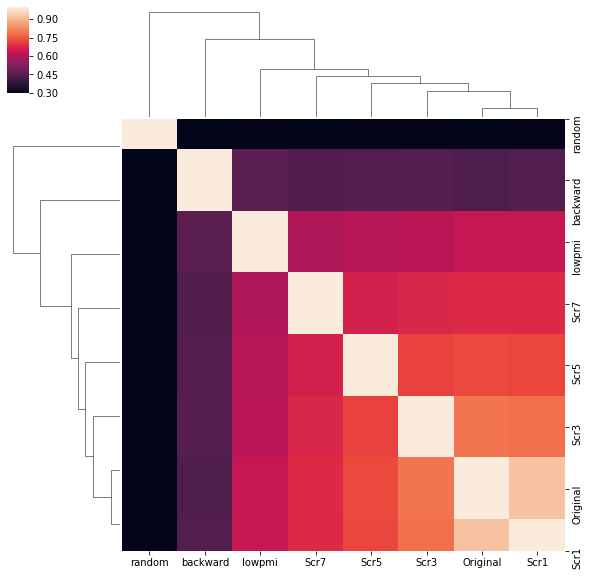

In [126]:
df_lm1b = main_df_for_plotting("lm_1b")
sns.clustermap(df_lm1b.corr())

100%|██████████| 4200/4200 [00:11<00:00, 360.95it/s]  


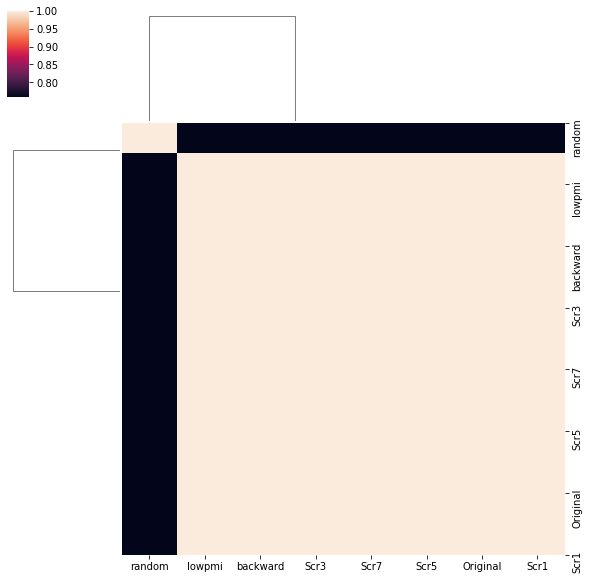

In [127]:
df_glove = main_df_for_plotting("glove")
sns.clustermap(df_glove.corr())

# 2. Look at different layers

In [154]:
df_lm1b_encoderh0 = main_df_for_plotting("distilgpt2",layer_identifier="encoder.h.0")

  4%|▍         | 176/4200 [00:00<00:02, 1617.49it/s]

This is the layer I'm looking at:  encoder.h.0


100%|██████████| 4200/4200 [00:18<00:00, 227.63it/s]


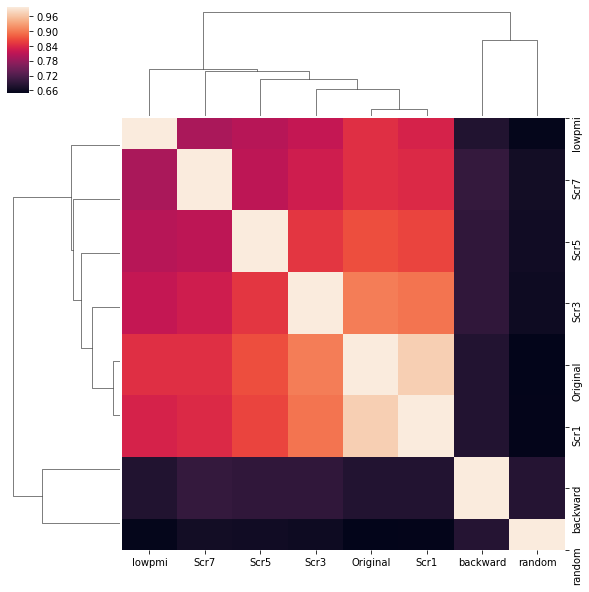

In [136]:
sns.clustermap(df_lm1b_encoderh0.corr())

In [255]:
def get_correlation_dfs_for_all_layers(model_identifier):
    layers = get_all_layers(model_identifier)
    df_dict = {}
    for ind,elm in enumerate(layers):
        df_dict[elm] = main_df_for_plotting(model_identifier,layer_identifier=elm)
    return df_dict

# 2.b Try looping through layers and put into subplots

### Caveat: Can't do ClusterGrid, as the graph cannot take ax as input. Look into how to do this if we want to

In [304]:
glove_correlation_dict = get_correlation_dfs_for_all_layers("glove")

 36%|███▋      | 1523/4200 [00:00<00:00, 14943.42it/s]

This is the layer I'm looking at:  projection


100%|██████████| 4200/4200 [00:11<00:00, 353.45it/s]  


In [257]:
print(len(glove_correlation_dict))

1


In [258]:
lm1b_correlation_dict = get_correlation_dfs_for_all_layers("lm_1b")

 68%|██████▊   | 2865/4200 [00:00<00:00, 27542.05it/s]

This is the layer I'm looking at:  lstm/lstm_0/control_dependency


 68%|██████▊   | 2865/4200 [00:00<00:00, 27316.41it/s]

This is the layer I'm looking at:  lstm/lstm_1/control_dependency


100%|██████████| 4200/4200 [00:14<00:00, 290.03it/s]  


In [259]:
print(len(lm1b_correlation_dict))

2


In [300]:
import math
import matplotlib.pyplot as plt

def get_subplots(dictionary,model_name):
    number_subplots = len(dictionary)
    number_rows = math.ceil(number_subplots/2)
    
    fig, ax = plt.subplots(number_rows,2, figsize=(15, 7*number_rows))
    ax = ax.flatten()
    fig.suptitle(model_name, fontsize=26)
    
    counter = 0
    for key, value in dictionary.items():
            sns.heatmap(value.corr(), ax=ax[counter])
            ax[counter].set_title(key, fontsize=16)
            counter += 1

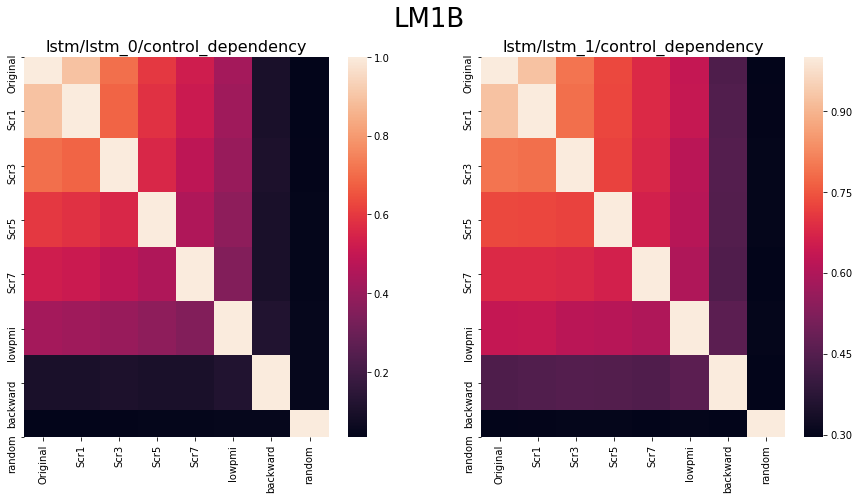

In [301]:
get_subplots(lm1b_correlation_dict, "LM1B")

# DistilGPT2

In [273]:
distilgpt2_correlation_dict = get_correlation_dfs_for_all_layers("distilgpt2")

  4%|▍         | 176/4200 [00:00<00:02, 1647.50it/s]

This is the layer I'm looking at:  drop


  4%|▍         | 176/4200 [00:00<00:02, 1611.04it/s]

This is the layer I'm looking at:  encoder.h.0


  4%|▍         | 176/4200 [00:00<00:02, 1742.29it/s]

This is the layer I'm looking at:  encoder.h.1


  4%|▍         | 176/4200 [00:00<00:02, 1685.06it/s]

This is the layer I'm looking at:  encoder.h.2


  4%|▍         | 176/4200 [00:00<00:02, 1568.93it/s]

This is the layer I'm looking at:  encoder.h.3


  4%|▍         | 176/4200 [00:00<00:02, 1713.09it/s]

This is the layer I'm looking at:  encoder.h.4


  4%|▍         | 175/4200 [00:00<00:02, 1672.06it/s]

This is the layer I'm looking at:  encoder.h.5


100%|██████████| 4200/4200 [00:18<00:00, 227.28it/s]


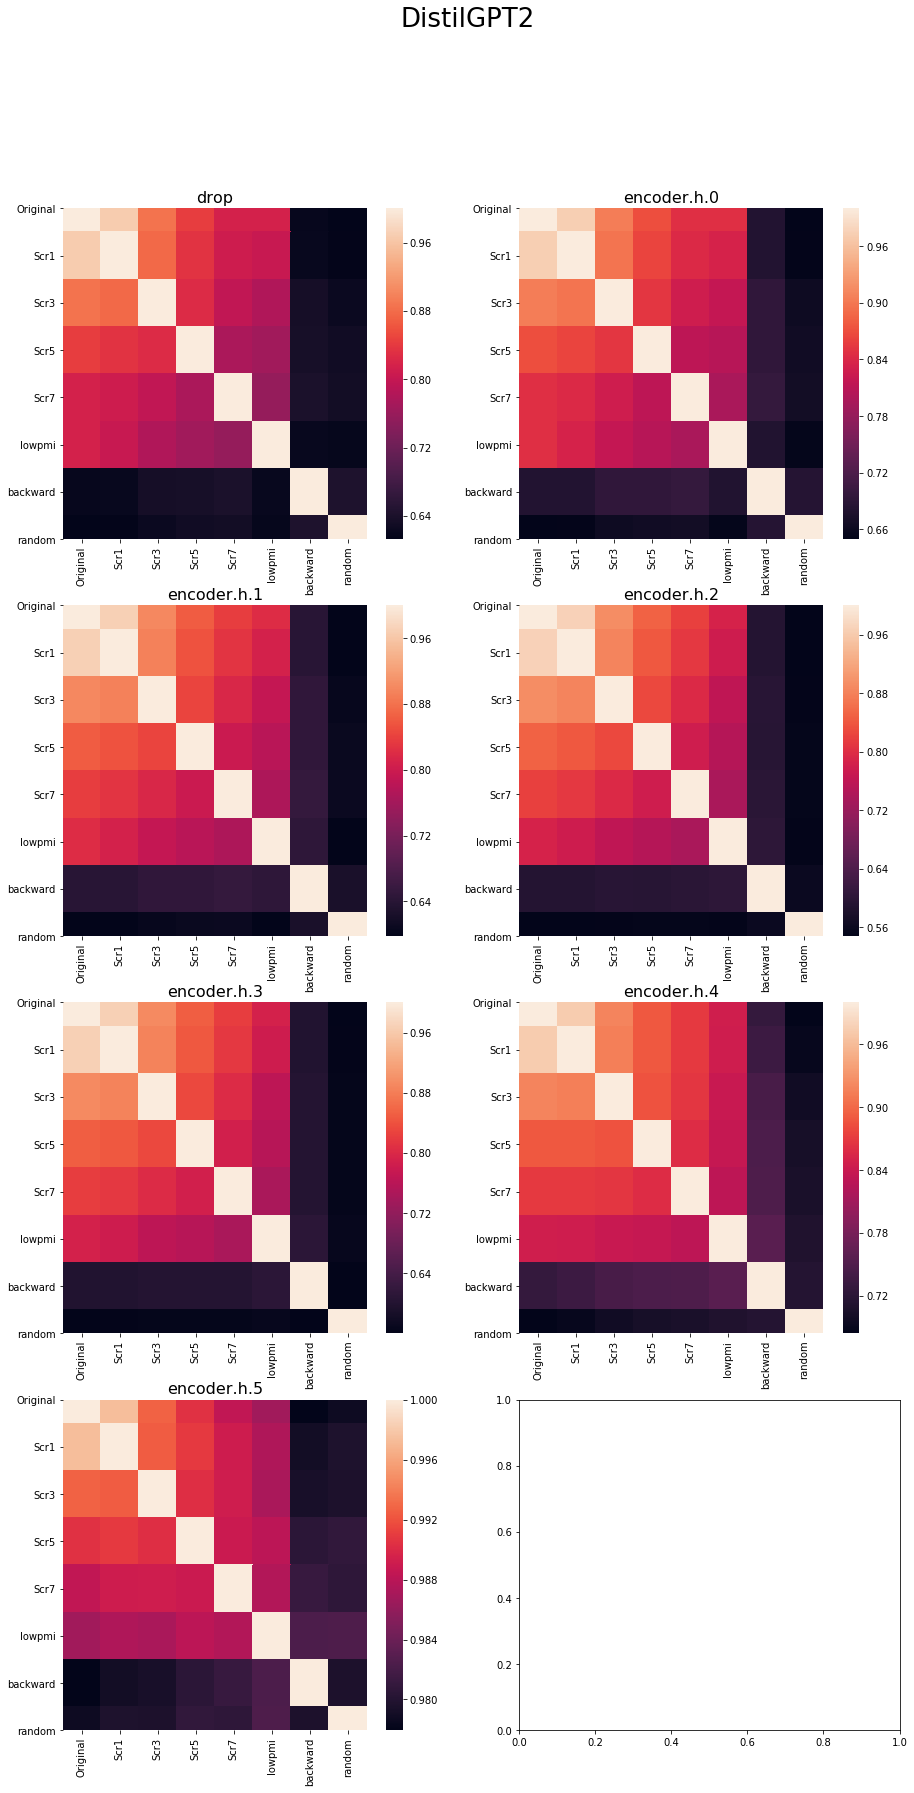

In [302]:
get_subplots(distilgpt2_correlation_dict, "DistilGPT2")

### Glove

 36%|███▋      | 1523/4200 [00:00<00:00, 15137.87it/s]

This is the layer I'm looking at:  projection


100%|██████████| 4200/4200 [00:11<00:00, 363.73it/s]  


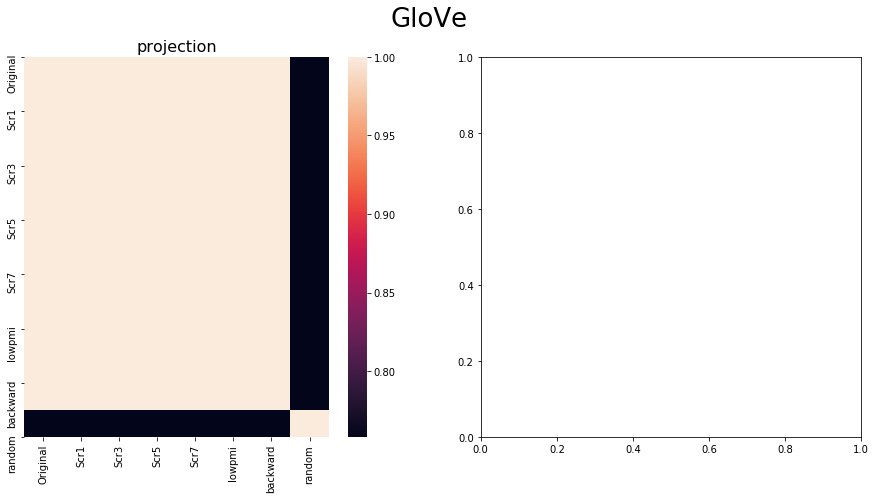

In [305]:
glove_correlation_dict = get_correlation_dfs_for_all_layers("glove")
get_subplots(glove_correlation_dict, "GloVe")